## Sentiment Classification

We have made use of the Internet Movie Database, popularly known as
IMDb (www.imdb.com), to select the dataset for the sentiment classification
problem. It offers a great number of datasets, both image and text, which
are useful for multiple research activities in deep learning and data
analysis.

For sentiment classification, we have made use of a set of 25,000
movie reviews, which have their positive and negative label attached.
The publicly available reviews have been already preprocessed and are
encoded as a sequence of word indexes, i.e., integers. The words are ordered on the basis of their overall frequency in the dataset, i.e., the token
or word with the second-highest frequency has been indexed as 2, and so
on. Attaching such an index to the words will help in shortlisting the words
on the basis of their frequency, such as to pick the top 2,000 most common
words or remove the top-10 most common words

In [8]:
# keras.datasets.imdb is broken in 1.13 and 1.14, by np 1.16.3
!pip install tf_nightly

  Using cached https://files.pythonhosted.org/packages/5e/c8/2c38f2e1d9a2a40d368e05f870e57c5e104d4a2a16ee45bd53ac56fc8e30/tf_nightly-1.14.1.dev20190515-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/ab/9f/ef1a3fea8d6426508ff4849d8f85ce4a86ebae5d1f03c65705e950cf9e0c/tb_nightly-1.14.0a20190515-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f9/68/a14620bfb042691f532dcde8576ff82ee82e4c003cdc0a3dbee5f289cee6/google_pasta-0.1.6-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/35/3b/aadf6561d786f073509982cf842b14f806198918b610ca049dbd374cd4b9/tf_estimator_nightly-1.14.0.dev2019051501-py2.py3-none-any.whl


In [28]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import rnn, rnn_cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

1.14.1-dev20190515


In [29]:
from keras.datasets import imdb

**Fix the error: allow_pickle=True:**

Downgraded numpy version from 1.16.3 to 1.16.1 which default value is still allow_pickle=True. 
Just remove current version then install the 1.16.1 version via:

pip uninstall numpy
pip install --upgrade numpy==1.16.1

**Download the IMDB dataset**
The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):

In [30]:
(X_train,y_train), (X_test,y_test) = imdb.load_data(num_words=1000, index_from=3)

**Convert the integers back to words**

It may be useful to know how to convert integers back to text. 
Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [31]:
# Getting the word index used for encoding the sequences
vocab_to_int = imdb.get_word_index()

# The first indices are reserved
vocab_to_int = {k:(v+3) for k,v in vocab_to_int.items()}  # Starting from word index offset onward
# Creating indexes for the special characters : Padding, Start Token, Unknown words
vocab_to_int["<PAD>"] = 0
vocab_to_int["<GO>"] = 1
vocab_to_int["<UNK>"] = 2

In [32]:
int_to_vocab = {value:key for key,value in vocab_to_int.items()}

In [33]:
print(' '.join(int_to_vocab[id] for id in X_train[0] ))

<GO> this film was just brilliant casting <UNK> <UNK> story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> <UNK> as myself so i loved the fact there was a real <UNK> with this film the <UNK> <UNK> throughout the film were great it was just brilliant so much that i <UNK> the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the <UNK> <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you <UNK> at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> <UNK> i think because the stars that play them all <UNK> up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they have done don't you t

**Another way to do the same thing**

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in vocab_to_int.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [14]:
decode_review(X_train[0])

"<GO> this film was just brilliant casting <UNK> <UNK> story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> <UNK> as myself so i loved the fact there was a real <UNK> with this film the <UNK> <UNK> throughout the film were great it was just brilliant so much that i <UNK> the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the <UNK> <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you <UNK> at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> <UNK> i think because the stars that play them all <UNK> up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they have done don't you 

**Prepare the Data**

In [34]:
# Creating Train and Test datasets from labeled movie reviews 
(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb_full.pkl",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [35]:
t = [item for sublist in X_train for item in sublist]
vocabulary = len(set(t))+1

**shows the distribution of the word count in reviews**

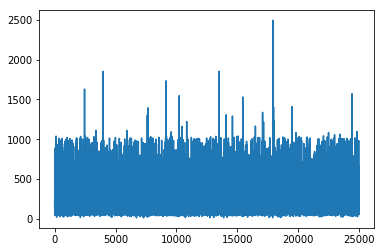

In [36]:
a = [len(x) for x in X_train]
plt.plot(a)

**Specify a maximum length for the selection of a sequence from the sentence**

If the review length is lower than it, append the newly
created sequence with padding, up to the maximum length.

In [37]:
max_length = 200 # specifying the max length of the sequence in the sentence
x_filter = []
y_filter = []

# if the selected length is lesser than the specified max_length, 200, then appending padding (0), else only selecting
#       desired length only from sentence
for i in range(len(X_train)):
    if len(X_train[i])<max_length:
        a = len(X_train[i])
        X_train[i] = X_train[i] + [0] * (max_length - a)
        x_filter.append(X_train[i])
        y_filter.append(y_train[i])
    elif len(X_train[i])>max_length:
        X_train[i] = X_train[i][0:max_length]

**Model Hyperparameters**

Declare the model hyperparameters with word embedding size,
number of hidden units, learning rate, batch size, and total number of
training iterations.

In [38]:
#declaring the hyper params
embedding_size = 100 # word vector size for initializing the word embeddings
n_hidden = 200
learning_rate = 0.06
training_iters = 100000
batch_size = 32
beta =0.0001

**Additional Parameters**

There are related to the current model architecture 

- dataset
- max_length
- number of classes to classify 

in, number of units in hidden layer of self-attention MLP, and number of rows in matrix embedding.

In [39]:
n_steps = max_length  # timestepswords
n_classes = 2         # 0/1 : binary classification for negative and positive reviews
da = 350              # hyper-parameter : Self-attention MLP has hidden layer with da units
r = 30                # count of different parts to be extracted from sentence (= # rows in matrix embedding)
display_step =10 
hidden_units = 3000

Transform the training dataset values and labels in the desired format
of array post transformation and encoding, respectively.

In [40]:
y_train = np.asarray(pd.get_dummies(y_filter))
X_train = np.asarray([np.asarray(g) for g in x_filter])

Create an internal folder to record logs

In [41]:
logs_path = './recent_logs/'

In [ ]:
#NAME = "lstmumich{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

Create a class, to yield random data in batches of given batch size.

In [43]:
class DataIterator:
    def __init__(self, data1,data2, batch_size):
        self.data1 = data1
        self.data2 = data2
        self.batch_size = batch_size
        self.iter = self.make_random_iter()
        
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X =[self.data1[i] for i in idxs]
        Y =[self.data2[i] for i in idxs]
        
        X = np.array(X)
        Y = np.array(Y)
        return X, Y

    def make_random_iter(self):
        splits = np.arange(self.batch_size, len(self.data1), self.batch_size)
        it = np.split(np.random.permutation(range(len(self.data1))), splits)[:-1]
        return iter(it)

**Initialize weights and biases and input**

The general rule for setting the weights in a neural network is to be close
to zero, without being too small. A good practice is to start your weights in
the range of [−y, y], where: 

$ y = \frac{1} {\sqrt{n}} $

(n is the number of inputs to a given
neuron).

In [44]:
############ Graph Creation ################      

# TF Graph Input
with tf.name_scope("weights"):
    Win  = tf.Variable(tf.random_uniform([n_hidden*r, hidden_units],
                                          -1/np.sqrt(n_hidden),
                                          1/np.sqrt(n_hidden)), name='W-input')
    Wout = tf.Variable(tf.random_uniform([hidden_units, n_classes],
                                          -1/np.sqrt(hidden_units),
                                          1/np.sqrt(hidden_units)), name='W-out')
    Ws1  = tf.Variable(tf.random_uniform([da,n_hidden],
                                          -1/np.sqrt(da),
                                         1/np.sqrt(da)), name='Ws1')
    
    Ws2  = tf.Variable(tf.random_uniform([r,da],
                                         -1/np.sqrt(r),
                                         1/np.sqrt(r)), name='Ws2')

In [45]:
with tf.name_scope("biases"):            
    biasesout = tf.Variable(tf.random_normal([n_classes]), name='biases-out')
    biasesin  = tf.Variable(tf.random_normal([hidden_units]), name='biases-in')

In [46]:
with tf.name_scope('input'):
    x = tf.placeholder("int32", [32,max_length], name='x-input')
    y = tf.placeholder("int32", [32, 2], name='y-input')

Create tensors in the same default graph context with the embedded
vectors. This takes the embedding matrix and an input tensor, such as the
review vectors.

In [47]:
with tf.name_scope('embedding'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary, embedding_size],-1, 1), name='embeddings')
    embed = tf.nn.embedding_lookup(embeddings,x)

In [48]:
def length(sequence):
    # Computing maximum of elements across dimensions of a tensor
    used = tf.sign(tf.reduce_max(tf.abs(sequence), reduction_indices=2))   
    
    length = tf.reduce_sum(used, reduction_indices=1)
    length = tf.cast(length, tf.int32)
    return length

Reuse the weights and biases using the following:

In [49]:
with tf.variable_scope('forward',reuse=True):
        lstm_fw_cell = rnn_cell.BasicLSTMCell(n_hidden)


W0516 14:01:46.109194 47876 deprecation.py:323] From <ipython-input-49-4fa4132a33fc>:2: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [52]:
with tf.name_scope('model'):  
    outputs, states = rnn.dynamic_rnn(lstm_fw_cell,
                                      embed,sequence_length=length(embed),
                                      dtype=tf.float32,
                                      time_major=False)  

    # in the next step we multiply the hidden-vec matrix with the Ws1 by reshaping 
    h = tf.nn.tanh(tf.transpose(tf.reshape(tf.matmul(Ws1,tf.reshape(outputs,
                                                                    [n_hidden,batch_size*n_steps])), 
                                           [da,batch_size,n_steps]),[1,0,2]))
    # in this step we multiply the generated matrix with Ws2
    a = tf.reshape(tf.matmul(Ws2,tf.reshape(h,
                                            [da,batch_size*n_steps])),
                   [batch_size,r,n_steps])
    
    def fn3(a,x):
            return tf.nn.softmax(x)
    h3 = tf.scan(fn3,a)

In [53]:
with tf.name_scope('flattening'):
    # here we again multiply(batch) of the generated batch with the same hidden matrix
    h4 = tf.matmul(h3,outputs)
    # flattening the output embedded matrix
    last = tf.reshape(h4,[-1,r*n_hidden])

In [54]:

with tf.name_scope('MLP'):
    tf.nn.dropout(last,.5, noise_shape=None, seed=None, name=None)
    pred1 = tf.nn.sigmoid(tf.matmul(last,Win)+biasesin)
    pred  = tf.matmul(pred1, Wout) + biasesout

W0516 14:15:09.616365 47876 deprecation.py:506] From <ipython-input-54-aa67141db579>:3: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [55]:

# Define loss and optimizer
with tf.name_scope('cross'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits =pred, labels = y) + beta*tf.nn.l2_loss(Ws2) )

W0516 14:15:38.359052 47876 deprecation.py:323] From <ipython-input-55-daa06a6c8ffd>:4: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [56]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gvs = optimizer.compute_gradients(cost)
    capped_gvs = [(tf.clip_by_norm(grad,0.5), var) for grad, var in gvs]
    optimizer.apply_gradients(capped_gvs)
    optimized = optimizer.minimize(cost)

In [57]:
# Evaluate model
with tf.name_scope('Accuracy'):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy     = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [58]:
tf.summary.scalar("cost", cost)
tf.summary.scalar("accuracy", accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [59]:
# merge all summaries into a single "summary operation" which we can execute in a session 
summary_op =tf.summary.merge_all()

In [60]:

# Initializing the variables
train_iter = DataIterator(X_train,y_train, batch_size)    
init = tf.global_variables_initializer()

# This could give warning if in case the required port is being used already
# Running the command again or releasing the port before the subsequent run should solve the purpose

**Start to train the model.**

Make sure the batch_size is sufficient enough to fit system requirements.

In [61]:
with tf.Session() as sess:
    sess.run(init)
    # Creating log file writer object
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = train_iter.next_batch()
        sess.run(optimized, feed_dict={x: batch_x, y: batch_y})
        # Executing the summary operation in the session
        summary = sess.run(summary_op, feed_dict={x: batch_x, y: batch_y})
        # Writing the values in log file using the FileWriter object created above
        writer.add_summary(summary,  step*batch_size)
        if step % display_step == 2:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + \
                   ", Minibatch Loss= " + "{:.6f}".format(loss) + \
                   ", Training Accuracy= " + "{:.2f}".format(acc*100) + "%")
        step += 1
    print ("Optimization Finished!")

Iter 64, Minibatch Loss= 49.681767, Training Accuracy= 50.00%
Iter 384, Minibatch Loss= 0.701942, Training Accuracy= 53.12%
Iter 704, Minibatch Loss= 0.827410, Training Accuracy= 53.12%
Iter 1024, Minibatch Loss= 0.807983, Training Accuracy= 40.62%
Iter 1344, Minibatch Loss= 0.731755, Training Accuracy= 59.38%
Iter 1664, Minibatch Loss= 0.782390, Training Accuracy= 43.75%
Iter 1984, Minibatch Loss= 0.798124, Training Accuracy= 46.88%
Iter 2304, Minibatch Loss= 0.719862, Training Accuracy= 46.88%
Iter 2624, Minibatch Loss= 0.711035, Training Accuracy= 56.25%
Iter 2944, Minibatch Loss= 0.713115, Training Accuracy= 56.25%
Iter 3264, Minibatch Loss= 0.755966, Training Accuracy= 40.62%
Iter 3584, Minibatch Loss= 0.695097, Training Accuracy= 59.38%
Iter 3904, Minibatch Loss= 0.708559, Training Accuracy= 50.00%
Iter 4224, Minibatch Loss= 0.742921, Training Accuracy= 46.88%
Iter 4544, Minibatch Loss= 0.746765, Training Accuracy= 46.88%
Iter 4864, Minibatch Loss= 0.684644, Training Accuracy= 56

Iter 41344, Minibatch Loss= 0.764301, Training Accuracy= 46.88%
Iter 41664, Minibatch Loss= 0.688696, Training Accuracy= 59.38%
Iter 41984, Minibatch Loss= 0.731804, Training Accuracy= 43.75%
Iter 42304, Minibatch Loss= 0.710098, Training Accuracy= 46.88%
Iter 42624, Minibatch Loss= 0.688416, Training Accuracy= 59.38%
Iter 42944, Minibatch Loss= 0.704524, Training Accuracy= 53.12%
Iter 43264, Minibatch Loss= 0.688413, Training Accuracy= 59.38%
Iter 43584, Minibatch Loss= 0.922255, Training Accuracy= 46.88%
Iter 43904, Minibatch Loss= 0.698152, Training Accuracy= 59.38%
Iter 44224, Minibatch Loss= 0.922108, Training Accuracy= 40.62%
Iter 44544, Minibatch Loss= 0.696977, Training Accuracy= 59.38%
Iter 44864, Minibatch Loss= 0.708457, Training Accuracy= 46.88%
Iter 45184, Minibatch Loss= 0.712999, Training Accuracy= 50.00%
Iter 45504, Minibatch Loss= 0.705058, Training Accuracy= 56.25%
Iter 45824, Minibatch Loss= 0.716852, Training Accuracy= 56.25%
Iter 46144, Minibatch Loss= 0.738991, Tr

Iter 82624, Minibatch Loss= 0.708601, Training Accuracy= 50.00%
Iter 82944, Minibatch Loss= 0.817616, Training Accuracy= 46.88%
Iter 83264, Minibatch Loss= 0.716550, Training Accuracy= 34.38%
Iter 83584, Minibatch Loss= 0.654846, Training Accuracy= 65.62%
Iter 83904, Minibatch Loss= 0.685152, Training Accuracy= 59.38%
Iter 84224, Minibatch Loss= 0.703475, Training Accuracy= 50.00%
Iter 84544, Minibatch Loss= 0.707668, Training Accuracy= 50.00%
Iter 84864, Minibatch Loss= 0.750228, Training Accuracy= 53.12%
Iter 85184, Minibatch Loss= 0.718305, Training Accuracy= 53.12%
Iter 85504, Minibatch Loss= 0.697662, Training Accuracy= 62.50%
Iter 85824, Minibatch Loss= 0.753453, Training Accuracy= 50.00%
Iter 86144, Minibatch Loss= 0.741124, Training Accuracy= 46.88%
Iter 86464, Minibatch Loss= 0.725558, Training Accuracy= 50.00%
Iter 86784, Minibatch Loss= 0.799057, Training Accuracy= 43.75%
Iter 87104, Minibatch Loss= 0.711870, Training Accuracy= 46.88%
Iter 87424, Minibatch Loss= 0.760621, Tr

For the graph visualization type the next line in your terminal inside of the project folder:
    
    tensorboard --logdir=./ --port=6006

The graph shows the variables that have been scoped
throughout the code, which helps in understanding the flow of the data
and connections across the model.

<img src="network_structure.JPG">

The Figure shows the MLP component of the graph, which is used to
add the addition of dropout to the last layer, and the sigmoid function to
predict the final sentiment classification results. The final predictions are
further used to gather the model’s accuracy and cost.

<img src="MLP.JPG">